In [24]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from kmodes.kprototypes import KPrototypes
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from IPython.display import display
import io
from matplotlib import cm 
from sklearn.metrics import silhouette_samples
from sklearn.decomposition import PCA
from mpl_toolkits import mplot3d
import seaborn as sns


In [3]:
df = pd.read_csv('edited_df.csv')

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [4]:
df.shape

(397884, 8)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397884 entries, 0 to 397883
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    397884 non-null  int64  
 1   StockCode    397884 non-null  object 
 2   Description  397884 non-null  object 
 3   Quantity     397884 non-null  int64  
 4   InvoiceDate  397884 non-null  object 
 5   UnitPrice    397884 non-null  float64
 6   CustomerID   397884 non-null  int64  
 7   Country      397884 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 24.3+ MB


# Feature Engineering 

First, I am going to create meaningful features for the analysis.This features is based on well known marketing analysis indicators in understanding customer behaviour which is **RFM(Recency, Frequency and Monetary)**.

Here's a quick definition of RFM:
- **Recency**: How recent customer made a purchase
- **Frequency**: How often customer made a purchase 
- **Monetary**: How much money customer spends on purchases

This concept was introduced in 1995 and still highly relevant to date. RFM mainly use to uderstand firm's best customer best on their purchasing behaviour. 

The main reason why I chose to use RFM before segmentation is to create meaningful variables and reduce the complexity of data to feed in to clustering algorithms. This decision also based on the data in hand itself which only consists of transaction records and highly relevant to RFM calculation. 

Let's dig it then !

In [6]:
#removes duplicates data 
df = df.drop_duplicates()
df.shape

(392692, 8)

In [7]:
df.dtypes

InvoiceNo        int64
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID       int64
Country         object
dtype: object

## Calculating RFM

In [8]:
# Converting Invoice data to date time format 
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format = '%Y-%m-%d %H:%M:%S')

# Creating Amount Column for Quantity*UnitPrice
df['Amount'] = df['Quantity'] * df['UnitPrice']

# Computing RFM 
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (df['InvoiceDate'].max()-x.max()).days, # Recency
    'InvoiceNo': 'count', # Frequency
    'Amount': 'sum' # Monetary
}).rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'Amount': 'Monetary'})

rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346,325,1,77183.60
12347,1,182,4310.00
12348,74,31,1797.24
12349,18,73,1757.55
12350,309,17,334.40


# K means

## K Means Data Preprocessing

### Distribution of Features

K means is distance based algorithm, and in this case I chose to use Euclidean distance to assign data points to cluster. Furthermore, K-means rely heavily on calculating mean (centroid), so when a feature is highly skewed, this skewness can pull the centroid away from the central tendency of the majority of data points. In regard to this, after checking the distribution of each variable and found out that they are highly right skewed, I decided to use log trasnformation.  

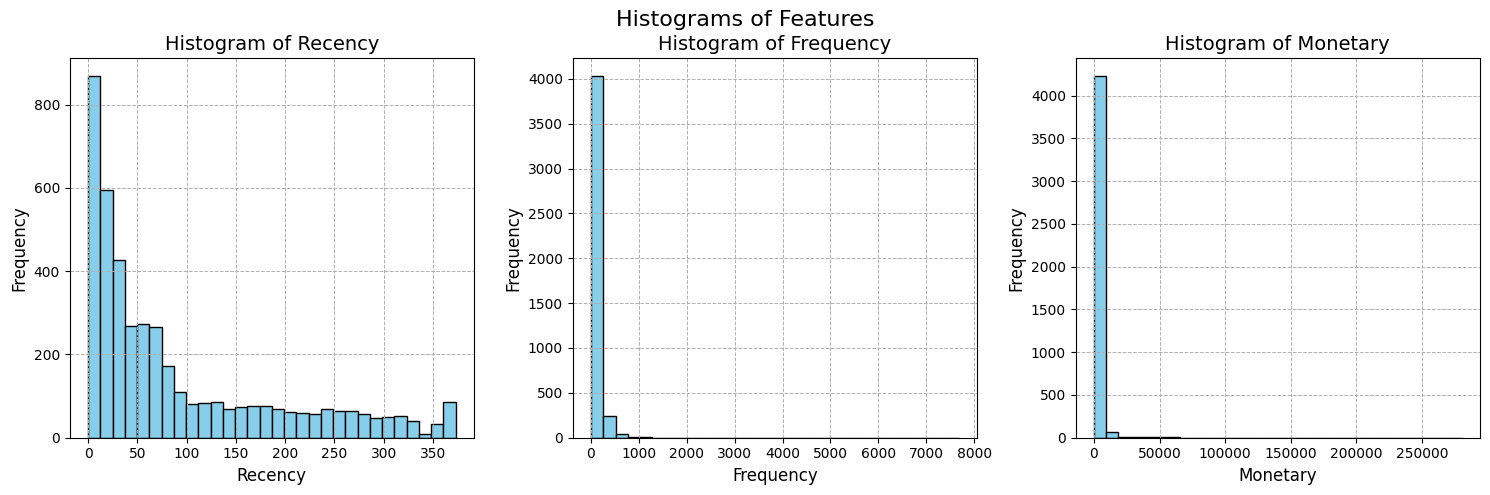

In [9]:
# List of features to plot
features = ['Recency', 'Frequency', 'Monetary']

# Number of features
n = len(features)

# Create subplots
fig, axes = plt.subplots(nrows=(n + 2) // 3, ncols=3, figsize=(15, 5 * ((n + 2) // 3)), sharex=False, sharey=False)

# Flatten axes array for easy indexing
axes = axes.flatten()

# Plot each feature
for i, feature in enumerate(features):
    ax = axes[i]
    ax.hist(rfm[feature], bins=30, color='skyblue', edgecolor='black')
    ax.set_title(f'Histogram of {feature}', fontsize=14)
    ax.set_xlabel(feature, fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.grid(True, which='both', linestyle='--', linewidth=0.7)

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.suptitle('Histograms of Features', fontsize=16, y=0.98)

plt.savefig('RFM_dsitribution.png', format='png', dpi=300, bbox_inches='tight')

plt.show()


In [10]:
# applying log transformation 
rfm_log = pd.DataFrame()

for feature in features:
    rfm_log[f'{feature}'] = np.log1p(rfm[feature])

rfm_log

,Recency,Frequency,Monetary
CustomerID,,,
12346,5.786897,0.693147,11.253955
12347,0.693147,5.209486,8.368925
12348,4.317488,3.465736,7.494564
12349,2.944439,4.304065,7.472245
12350,5.736572,2.890372,5.815324
...,...,...,...
18280,5.627621,2.397895,5.201806
18281,5.198497,2.079442,4.404522
18282,2.079442,2.564949,5.187665


The histogram below show each feature distribution after log trasnformation, where the distributions look more normal.

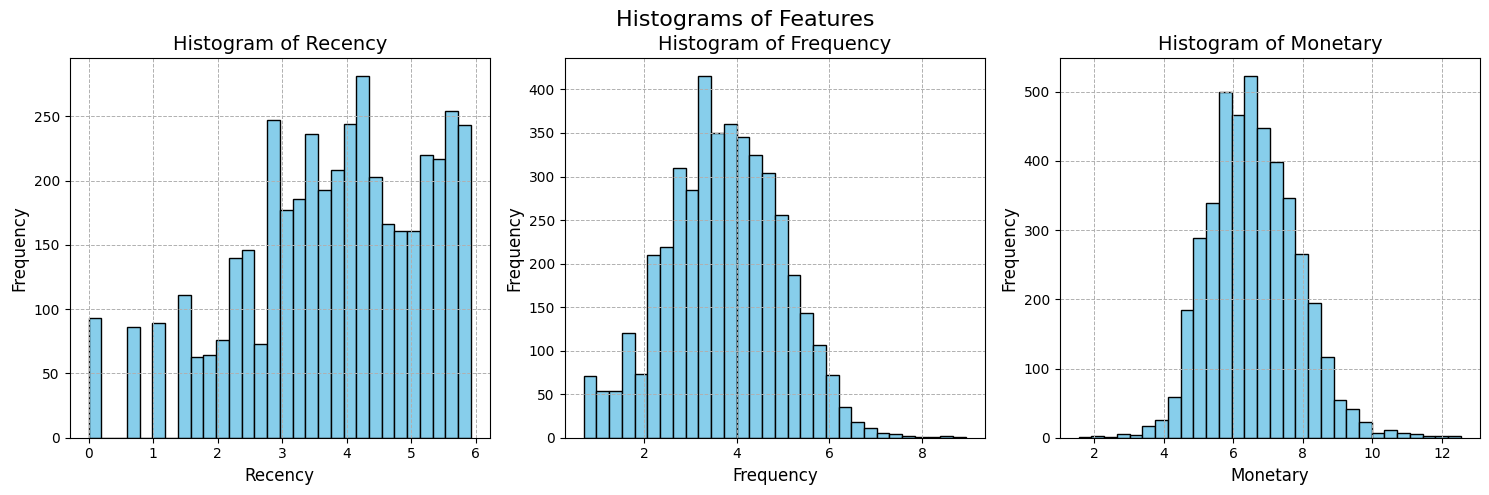

In [11]:
fig, axes = plt.subplots(nrows=(n + 2) // 3, ncols=3, figsize=(15, 5 * ((n + 2) // 3)), sharex=False, sharey=False)


axes = axes.flatten()

# Plot each feature
for i, feature in enumerate(features):
    ax = axes[i]
    ax.hist(rfm_log[feature], bins=30, color='skyblue', edgecolor='black')
    ax.set_title(f'Histogram of {feature}', fontsize=14)
    ax.set_xlabel(feature, fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.grid(True, which='both', linestyle='--', linewidth=0.7)

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.suptitle('Histograms of Features', fontsize=16, y=0.98)

plt.savefig('RFM_trasnformed.png', format='png', dpi=300, bbox_inches='tight')

plt.show()


Now, I standardized and scaled each variables 

In [12]:
# Normalizing 
sc = StandardScaler()
rfm_std = sc.fit_transform(rfm_log)
rfm_std = pd.DataFrame(rfm_std, columns= rfm_log.columns)

Here's the snippet of the data after standardization

In [13]:
rfm_std.head()

,Recency,Frequency,Monetary
0,1.409894,-2.438202,3.707716
1,-2.146498,1.188986,1.414903
2,0.383971,-0.211465,0.720024
3,-0.574674,0.461819,0.702287
4,1.374758,-0.673554,-0.614514


Next, I tried to find the best number of clusters using elbow method. Based on the elbow graph below, 4 clusters seem to be the best.

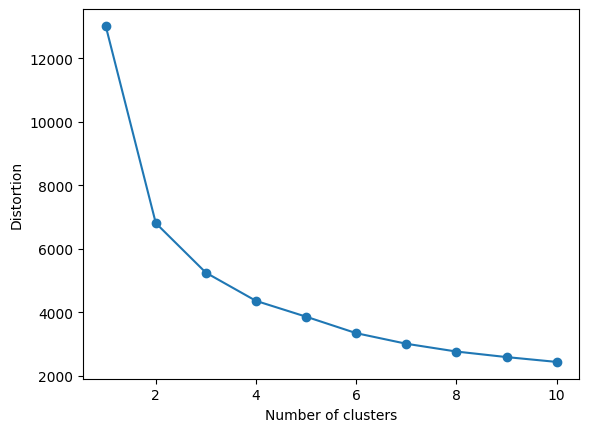

In [14]:
sse = []

for i in range(1,11):
    km = KMeans(n_clusters = i, 
                init = 'k-means++', 
                random_state= 0)
    km.fit(rfm_std)
    sse.append(km.inertia_)

plt.plot(range(1,11), sse, marker = 'o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

## Quantifying the quality of cluster via Silhoutte plots 

As we can see from the silhoutte plot below, all the clusters are above the avarage silhoutte scores and all the 4 plots are more or less of similar thickness and hence are of similar as sizes, which is in this case an indicator of good clustering. So, I will proceed with 4 number of cluster.

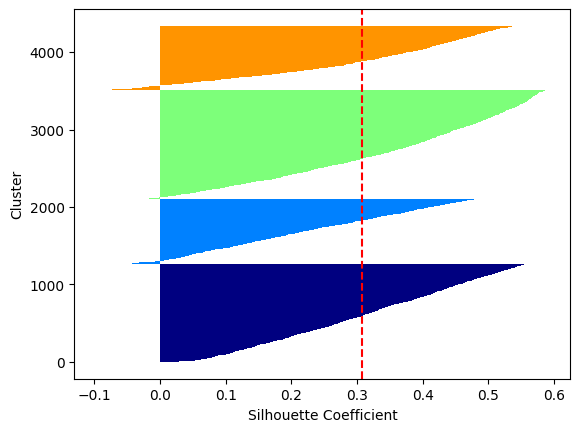

In [15]:
# Setting up Cluster
km = KMeans(n_clusters = 4, 
            init = 'k-means++',
            random_state = 0)

# Predicting values
y_predict = km.fit_predict(rfm_std)

y_predict

clusters_label = np.unique(y_predict) #cluesters values
n_clusters = clusters_label.shape[0] #total cluster 
vals = silhouette_samples(rfm_std, 
                   y_predict, 
                   metric = 'euclidean') #silhoutte score

y_ax_lower, y_ax_upper = 0,0

y_ticks = []
for i, c in enumerate(clusters_label):
    c_vals = vals[y_predict == c]
    c_vals.sort()
    y_ax_upper += len(c_vals)
    color = cm.jet(float(i)/n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), 
             c_vals,
             height = 1.0, 
             edgecolor = 'none', 
             color = color)
    y_ticks.append((y_ax_lower + y_ax_upper)/2.)
    y_ax_lower += len(c_vals)

silhoutte_avg = np.mean(vals)
plt.axvline(silhoutte_avg, 
            color = "red", 
            linestyle = "--")
plt.ylabel('Cluster')
plt.xlabel('Silhouette Coefficient')
plt.show()


## Cluster Visualization

I used PCA to reduce the dimensionality of the data and visualize the clusters in a 2D plot. Based on the PCA plot, we can observe four distinct clusters. The K-Means algorithm appears to have performed well, as there is minimal overlap between clusters.

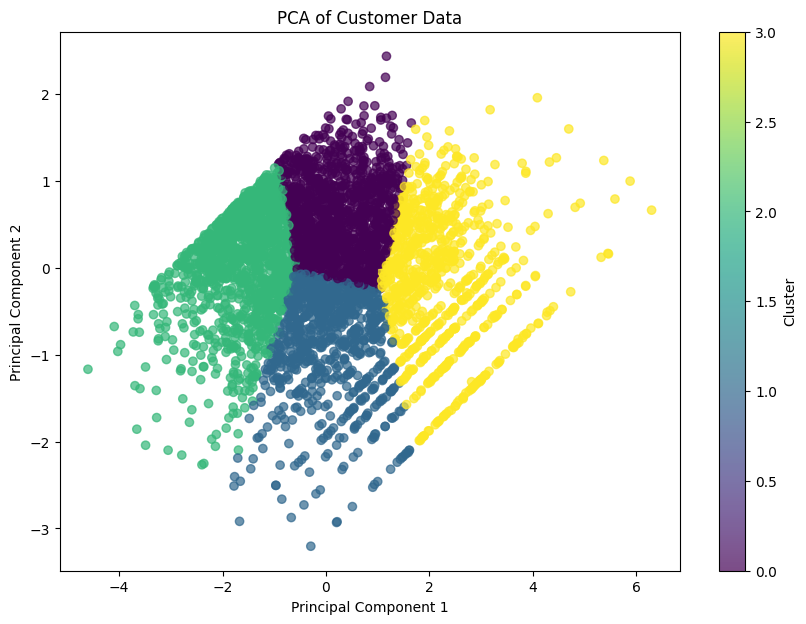

In [16]:
# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(rfm_std)
pc_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

pca_df = pd.DataFrame(data=pc_df, columns=['PC1', 'PC2'])
pca_df['Cluster'] = y_predict

plt.figure(figsize=(10, 7))

# Scatter plot of PCA results, colored by cluster
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Cluster'], cmap='viridis', alpha=0.7)

plt.title('PCA of Customer Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Cluster')

plt.savefig('K-means_pca.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

In [17]:
rfm_std['Cluster'] = y_predict
rfm_std.head()

,Recency,Frequency,Monetary,Cluster
0,1.409894,-2.438202,3.707716,0
1,-2.146498,1.188986,1.414903,3
2,0.383971,-0.211465,0.720024,0
3,-0.574674,0.461819,0.702287,0
4,1.374758,-0.673554,-0.614514,2


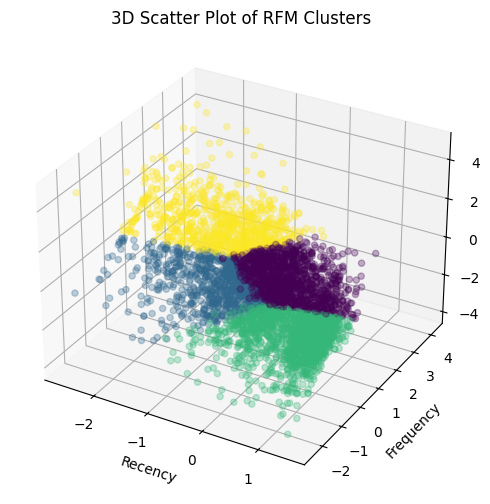

In [18]:
plt.figure(figsize=(10,6))
ax = plt.axes(projection = '3d')

#scatter plot 
ax.scatter3D(
    rfm_std['Recency'], 
    rfm_std['Frequency'], 
    rfm_std['Monetary'], 
    c = rfm_std['Cluster'], 
    cmap = 'viridis', 
    s = 20, 
    alpha = 0.3
)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

ax.set_title('3D Scatter Plot of RFM Clusters')

ax.view_init(elev=30) 

plt.savefig('k-mean_3D.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

## Summary of each Cluster

Let's try to understand what's happening on each cluster

In [19]:
# combine the data with cluster 
rfm['Cluster'] = y_predict
rfm.head()

,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12346,325,1,77183.60,0
12347,1,182,4310.00,3
12348,74,31,1797.24,0
12349,18,73,1757.55,0
12350,309,17,334.40,2


Here's the summary of each cluster:

- Cluster 3: This cluster consists of high-value customers. The average frequency of purchases and the total monetary value of these customers are the highest among all clusters, while their recency is the shortest. This indicates that customers in Cluster 3 are frequent buyers who make high-value purchases and have made recent transactions, making them highly engaged and valuable.

- Cluster 0: Following Cluster 3, Cluster 0 represents customers with moderate engagement. Although the average frequency and monetary value in this cluster are significantly lower than in Cluster 3, they are still higher than in the other clusters. However, the recency is longer compared to Cluster 3 and shorter than Cluster 1. This suggests that customers in Cluster 0 are moderately frequent buyers with relatively high purchase values, but it has been a while since their last purchase.

- Cluster 1: This cluster shows lower frequency and monetary values than Clusters 3 and 0, but the recency is higher than in Cluster 0. This means that while customers in Cluster 1 are less frequent buyers with lower purchase values, they have made recent purchases, indicating potential for re-engagement.

- Cluster 2: Customers in this cluster are considered low-value. They have the lowest frequency and monetary values and have not made purchases in a long time. This indicates a disengaged segment, with customers who rarely buy and whose purchases are of lower value.

In [20]:
pd.pivot_table(rfm, index = 'Cluster', aggfunc= 'mean')

,Frequency,Monetary,Recency
Cluster,,,
0,80.343106,1526.920644,92.748019
1,39.053318,616.831600,17.990521
2,15.050642,297.648160,182.154779
3,285.827711,7255.815000,11.412048


There are many customers clustered in cluster 2 and 0 and moderately in cluster 3 and 1 sequentially.

In [27]:
# counting number of customer in each cluster 
rfm.groupby('Cluster').size()

Cluster
0    1262
1     844
2    1402
3     830
dtype: int64

Here's the summary of each variable using standardized data

In [28]:
pd.pivot_table(rfm_std, index = 'Cluster', aggfunc= 'mean')

,Frequency,Monetary,Recency
Cluster,,,
0,0.389217,0.360813,0.362919
1,-0.218105,-0.319014,-0.780484
2,-0.972023,-0.911306,0.854311
3,1.271885,1.315124,-1.201227


We can also look, how each cluster differ to each other in terms of RFM through boxplot below.

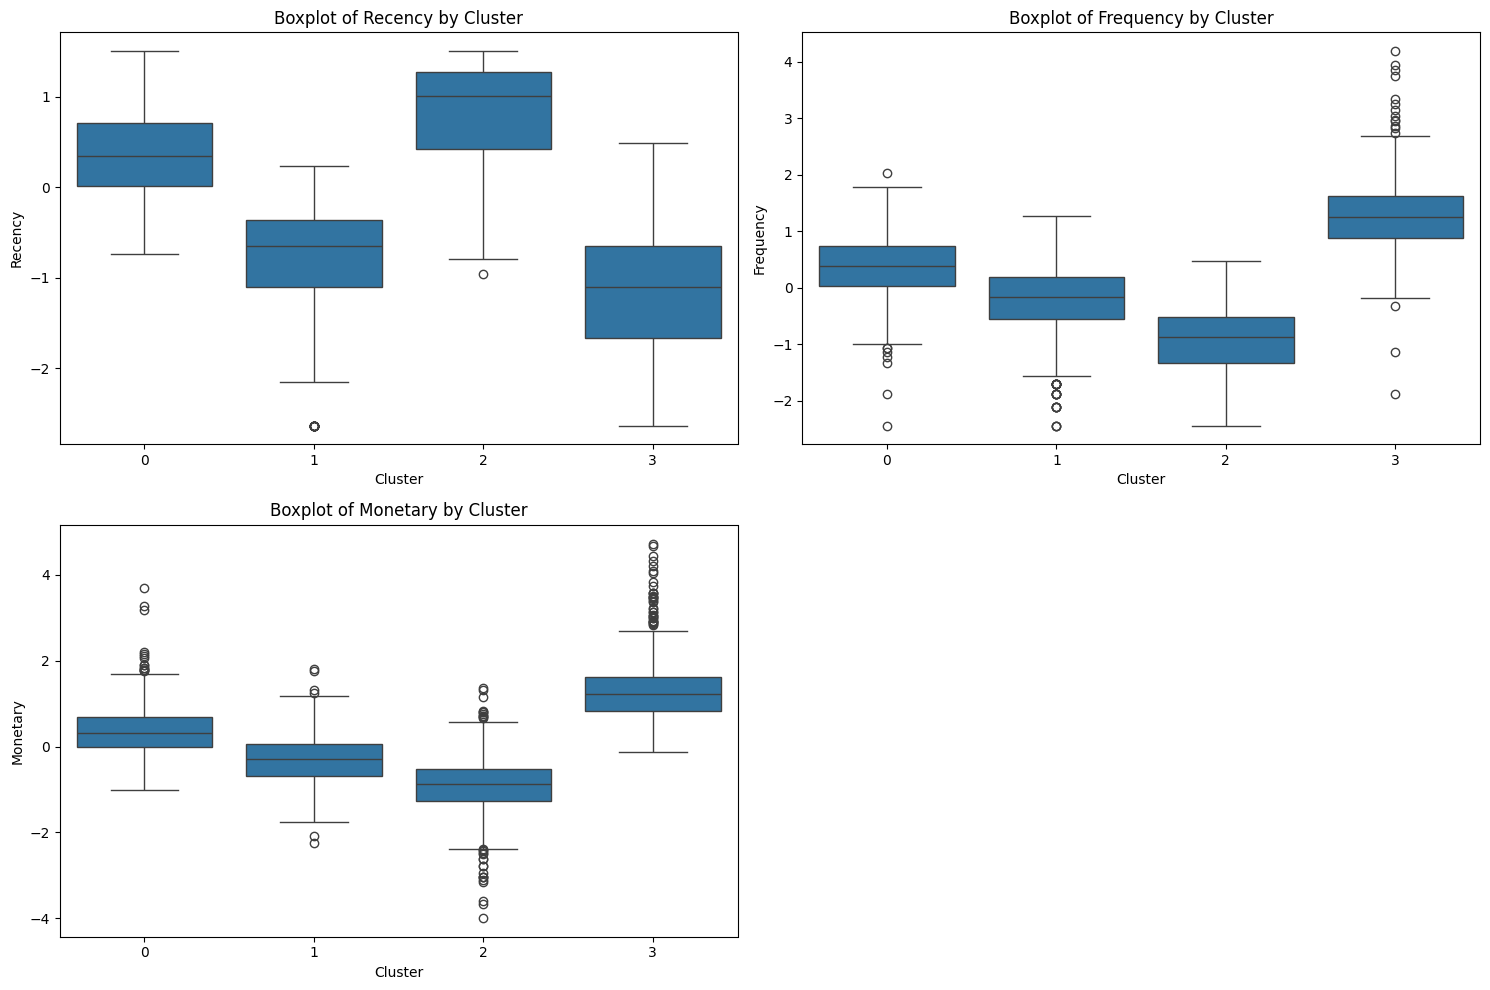

In [74]:
# visualizing how each features for each variable 
plt.figure(figsize=(15,10))

features = ['Recency', 'Frequency', 'Monetary']

for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x = 'Cluster', y = feature, data = rfm_std)
    plt.title(f'Boxplot of {feature} by Cluster')

plt.tight_layout()
plt.savefig('k-means_boxplot.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

We can also use percentiles: 25th, 50th (median), and 75th percentiles to understand the distribution of data more and the treshold. 

In [26]:
# categorize using percentiles 
percentiles = rfm.groupby('Cluster').quantile([0.25, 0.5, 0.75]).unstack(level=1)
print(percentiles)

        Recency                Frequency                  Monetary            \
           0.25   0.50    0.75      0.25   0.50    0.75       0.25      0.50   
Cluster                                                                        
0         43.00   70.0  118.75     42.25   67.0  103.00   711.9025  1091.960   
1          8.00   16.0   25.00     20.00   33.0   52.00   306.9975   496.885   
2         78.25  182.0  266.00      7.00   13.0   21.00   145.7000   241.355   
3          3.00    8.0   16.00    123.00  195.0  310.75  2085.9600  3351.960   

                    
              0.75  
Cluster             
0        1709.8525  
1         782.9500  
2         373.8675  
3        5647.5425  


In [27]:
# Saving percentiles output
percentiles_str = percentiles.to_string()

fig, ax = plt.subplots(figsize=(12, 8))  # Adjust size as needed
ax.text(0.5, 0.5, percentiles_str, fontsize=10, va='center', ha='center', family='monospace')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

plt.savefig('percentiles_output.png', bbox_inches='tight', pad_inches=0.1)
plt.close(fig)

# Conlusion and Recommendaions

Finally, the conclusion of this analysis is that there 4 segment of customers based on their purchasing behaviour. These 4 segments and marketing strategy for each of the segment:

- **Cluster 3**: is the store most valuable and active group, with high-frequency, high-monetary, and low-recency values, indicating highly engaged and valuable customers.
    - Recommendation: Loyalty Rewards & VIP Programs
        - Action: Offer exclusive rewards, discounts, or VIP programs to maintain their loyalty. Consider creating personalized offers based on their purchasing history to make them feel valued.
        - Goal: Strengthen customer retention by rewarding their frequent and high-value purchases, ensuring they remain engaged with the brand.
- **Cluster 0**: Moderately high-value customers with consistent purchasing behavior but slightly less recent activity.
    - Recommendation: Re-engagement Campaigns
        - Action: Encourage more frequent purchases by sending targeted promotions or incentives, such as limited-time offers or bundle deals. Highlight the benefits of staying active with the brand.
        - Goal: Increase purchase frequency and reduce the gap since their last purchase by re-engaging them with appealing offers.
- **Cluster 1**: Moderate-value customers who have made recent purchases, indicating potential for re-engagement.
    - Recommendation: Upselling & Cross-Selling
        - Action: Leverage their recent purchase activity by offering complementary products or upselling to higher-value items. Provide tailored recommendations based on their purchase history.
        - Goal: Boost average order value and further engage these customers by introducing them to products that align with their recent interests.
- **Cluster 2**: Low-value customers with infrequent purchases and long periods of inactivity.
    - Recommendation: Win-Back Campaigns
        - Action: Implement win-back campaigns to re-engage these inactive customers. Consider offering deep discounts, personalized messages, or reactivation incentives to encourage them to return.
        - Goal: Revitalize their interest in the brand and convert them from inactive to active customers by addressing potential reasons for their disengagement.


In [53]:
rfm.to_csv('rfm.csv')
rfm_std.to_csv('rfm_std.csv')